In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import interpolate
from CAMB import camb
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
wmap = np.loadtxt('wmap_tt_spectrum_9yr_v5.txt') #Extracting the data
multipoleIndex = wmap[:,0] #ydata
PP = wmap[:,1] #xdata
errPP = wmap[:,2] #Error on x data
errInst = wmap[:,3]
errCos = wmap[:,4]
pars = [multipoleIndex,PP,errPP,errInst,errCos]

In [28]:
#Defining the fit parameters
#[hubble constant, physical baryon density, cold dark matter density, optical depth, 
# primordial amplitude of fluctuations, slope of primordial power law]
ppp = np.asarray([65, 0.02, 0.1, 2e-09, 0.96])

In [16]:
def get_spectrum(pars,lmax=2000, fixed_tau=None):
    #print('pars are ',pars)
    if fixed_tau is None:
        H0=pars[0]
        ombh2=pars[1]
        omch2=pars[2]
        tau=pars[3]
        As=pars[4]
        ns=pars[5]
    else: 
        H0=pars[0]
        ombh2=pars[1]
        omch2=pars[2]
        tau=fixed_tau
        As=pars[3]
        ns=pars[4]
    pars=camb.CAMBparams()
    pars.set_cosmology(H0=H0,ombh2=ombh2,omch2=omch2,mnu=0.06,omk=0,tau=tau)
    pars.InitPower.set_params(As=As,ns=ns,r=0)
    pars.set_for_lmax(lmax,lens_potential_accuracy=0)
    results=camb.get_results(pars)
    powers=results.get_cmb_power_spectra(pars,CMB_unit='muK')
    cmb=powers['total']
    tt=cmb[:,0]
    return tt

In [17]:
#Define function to get gradient
#Taking the derivative of the spectrum (y data) by varying every parameter 
def derivative(x,y,p,dx,tau):
    #Define the matrix of to store the values
    gradient = np.zeros([len(x),len(p)])
    for i in range(len(p)):
        p_dx = p.copy() #Copy all of the input parameters
        p_derr = p_dx[i]*dx #Small variation of the parameter
        p_dx[i] = p_dx[i] + p_derr #Adding the derr to the parameter
        dx_1 = y(p_dx,fixed_tau=tau)[2:len(x)+2]
        
        p_dx[i] = p_dx[i] - 2*p_derr #Do the same but for the other direction
        dx_2 = y(p_dx,fixed_tau=tau)[2:len(x)+2]
        
        deriv = (dx_1-dx_2)/(2*p_derr) #The derivative is the difference between the new parameters/2*variation
        gradient[:,i] = np.asarray(deriv) #Turn matrix into np array
    return gradient

In [24]:
#We want to get the best fit values for the other parameters using Newton’s method/Levenberg Marquardt minimizer
def newtons_method(x,y,p,errP,tau):
    #Take the derivative of the function we are given (spectrum)
    grad = derivative(x,y,p,0.001,tau)
    #Get the new parameters
    p_new = p.copy()
    #Assume that we are far from the solution and start with a large chi^2
    chi_sq = 10000
    #Set the damping parameter to a very low value
    damp = 0.0001
    
    for j in range(100):
        guess = y(p_new,fixed_tau=tau)[2:len(x)+2] #Compute predicted y values
        residual = x - guess 
        chi_sq_new = (residual**2/errP**2).sum() #Define a new chi^2
        cond = chi_sq - chi_sq_new #New chi^2 to compare
        
        #If we are approaching the solution
        if cond>0 and cond<0.001:
            print (f"The final chi^2 is {chi_sq_new}")
            p = p_new.copy() #Copy new parameters
            grad = derivative(x,y,p,0.001,tau) #Define the gradient with a fixed optical length
            N = np.diag(1/errP**2) #Extract a diagonal or construct a diagonal array
            covar = np.dot(grad.transpose(),N) #Dot product of two arrays
            covar = np.dot(covar,grad)
            covar = np.linalg.inv(covar)
            err = np.sqrt(np.diag(covar))
            break
        #If the new chi^2 is larger than the old one, adjust the damping parameter
        elif chi_sq_new > chi_sq: 
            damp = 100*damp #Make the new damping factor have a larger effect on the parameters
            p_new = p.copy() 
        else:
            #If the new chi^2 is the same as the old one, decrease the damping factor
            chi_sq = chi_sq_new
            p = p_new.copy()
            damp = damp/10
            grad = derivative(x,y,p,0.001,tau) #Get the gradient again with a fixed optical depth
        
        res = np.matrix(residual).transpose() #Get the prediction
        grad = np.matrix(grad) #Get the gradient, A_m
        lhs = grad.transpose()*np.diag(1/errP**2)*grad #np.diag(1/errP**2) is noise
        LHS  = lhs+damp*np.diag(np.diag(lhs))
        rhs = grad.transpose()*np.diag(1/errP**2)*res
        dp = np.linalg.inv(LHS)*(rhs) #delta_m
        #For every parameter, update it
        for k in range(len(p)):
            p_new[k] = p_new[k] + dp[k]
        print (f"We are currently in iteration {j}; the chi-squared is {chi_sq}")
        print (damp,'\n')

    return p,covar,err

In [30]:
params1,covar1,err1 = newtons_method(wmap[:,1],get_spectrum,ppp,wmap[:,2],0.05)

We are currently in iteration 0; the chi-squared is 1588.2376532931526
1e-05 

We are currently in iteration 1; the chi-squared is 1234.8043585874339
1.0000000000000002e-06 

We are currently in iteration 2; the chi-squared is 1227.9369042959056
1.0000000000000002e-07 

We are currently in iteration 3; the chi-squared is 1227.9356356155058
1.0000000000000002e-08 

The final chi^2 is 1227.935633881174


Text(0, 0.5, 'Power Spectrum')

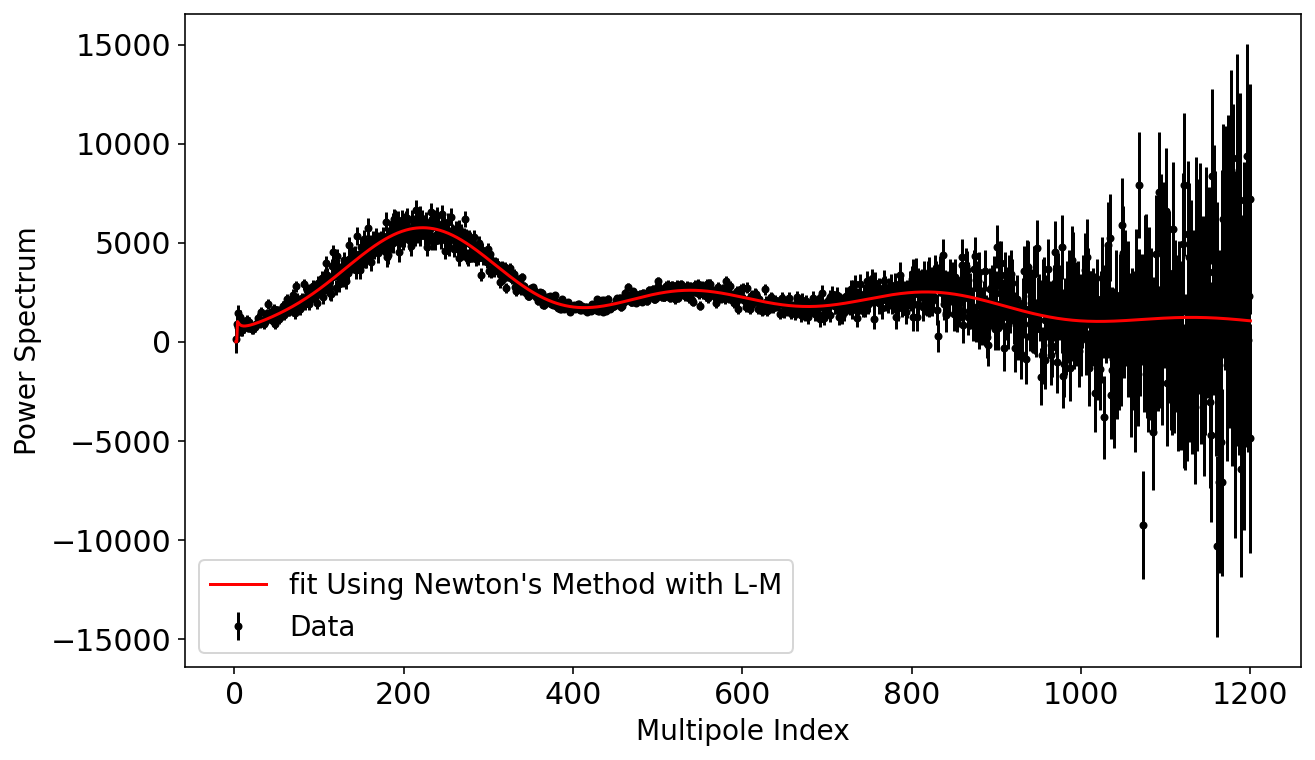

In [33]:
spec1 = get_spectrum(params1,lmax=2000,fixed_tau=0.05)
fig,ax = plt.subplots(1,1,figsize=(10,6))
ax.errorbar(wmap[:,0],PP, yerr=errPP, fmt='.',color='black',label='Data', zorder=1)
ax.plot(wmap[:,0],spec1[:1199],'-',color='red',label='fit Using Newton\'s Method with L-M')
plt.legend(loc='lower left', fontsize=14)
ax.tick_params(labelsize=15)
ax.set_xlabel('Multipole Index', fontsize=14)
ax.set_ylabel('Power Spectrum', fontsize=14)

In [26]:
ppp = np.asarray([65, 0.02, 0.1, 0.05, 2e-09, 0.96])
params,covar,err = newtons_method(wmap[:,1],get_spectrum,ppp,wmap[:,2],None)

We are currently in iteration 0; the chi-squared is 1588.2376532931526
1e-05 

We are currently in iteration 1; the chi-squared is 1235.5195584397115
1.0000000000000002e-06 

We are currently in iteration 2; the chi-squared is 1227.9837157010481
1.0000000000000002e-07 

We are currently in iteration 3; the chi-squared is 1227.9837157010481
1.0000000000000003e-05 

We are currently in iteration 4; the chi-squared is 1227.9837157010481
0.0010000000000000002 

We are currently in iteration 5; the chi-squared is 1227.9837157010481
0.10000000000000002 

We are currently in iteration 6; the chi-squared is 1227.9837157010481
10.000000000000002 

We are currently in iteration 7; the chi-squared is 1227.9837157010481
1000.0000000000002 

We are currently in iteration 8; the chi-squared is 1227.978698278534
100.00000000000003 

We are currently in iteration 9; the chi-squared is 1227.9721362506432
10.000000000000004 

We are currently in iteration 10; the chi-squared is 1227.930305375363
1.00000

Text(0, 0.5, 'Power Spectrum')

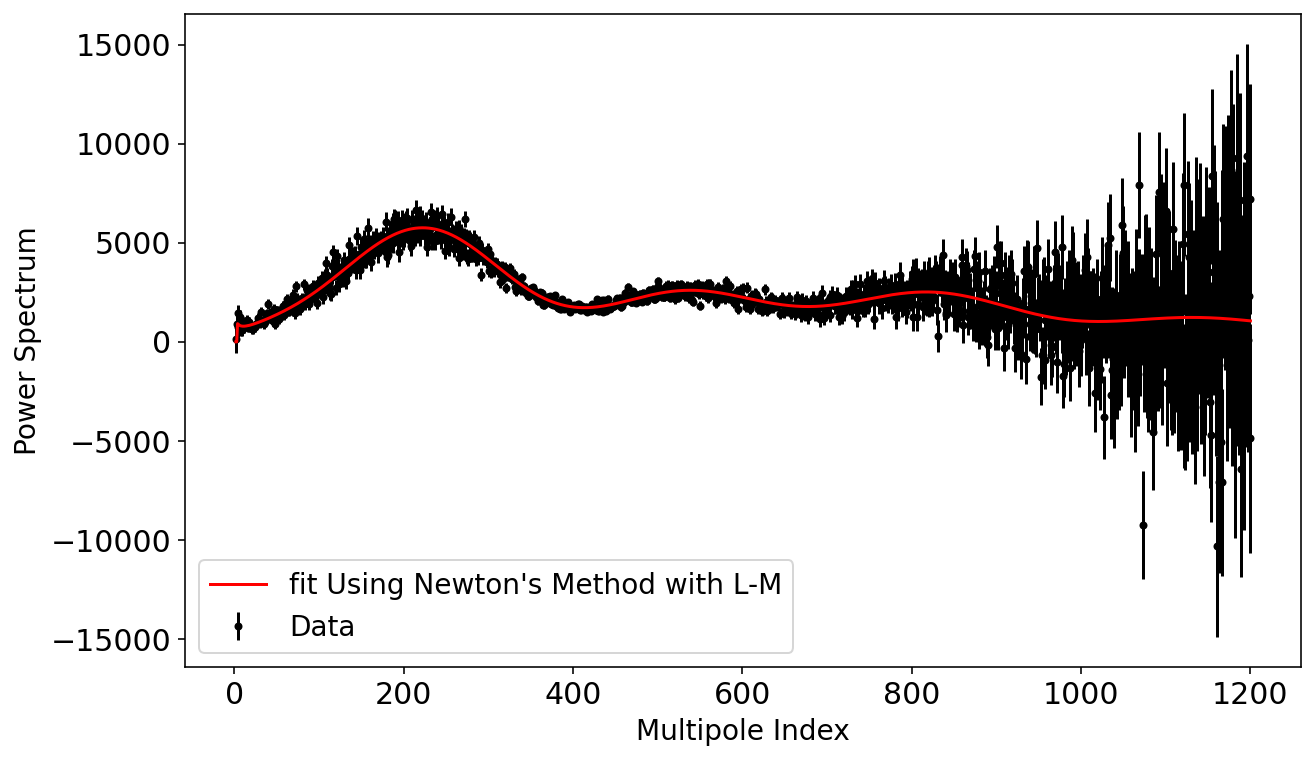

In [36]:
spec2 = get_spectrum(params,lmax=2000,fixed_tau=None)
fig,ax = plt.subplots(1,1,figsize=(10,6))
ax.errorbar(wmap[:,0],PP, yerr=errPP, fmt='.',color='black',label='Data', zorder=1)
ax.plot(wmap[:,0],spec2[:1199],'-',color='red',label='fit Using Newton\'s Method with L-M')
plt.legend(loc='lower left', fontsize=14)
ax.tick_params(labelsize=15)
ax.set_xlabel('Multipole Index', fontsize=14)
ax.set_ylabel('Power Spectrum', fontsize=14)

As expected, the new errors have decreased for a floating tau. This makes sense because without a given tau, the fit has less restraints. 

The plots above show what happens when a tau is given, and when a tau is not passed into newton's method to get new parameters, respectively. The chi^2 is slightly lower for the second fit, where the fit has one less input parameter guessed.